In [40]:
# --- Core Libraries ---
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# --- Visualization Libraries ---
import matplotlib.pyplot as plt

# --- Forecasting Models ---
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

# --- Prophet Diagnostics ---
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# --- Evaluation Metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [41]:
# --- Load Sales Data ---
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET-in-the-Pharmaceutical-Industry/Alton_20_Sales_Data_2014_2024.xlsx"

try:
    sales_data = pd.read_excel(file_path)
    print("Sales data loaded successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    sales_data = pd.DataFrame()
except Exception as e:
    print(f"Error loading file: {e}")
    sales_data = pd.DataFrame()

# --- Preview Raw Data ---
if not sales_data.empty:
    print("\n🔍 First 5 rows of raw data:")
    display(sales_data.head())
else:
    print("\n⚠️ No data to display.")


Sales data loaded successfully.

🔍 First 5 rows of raw data:


,ds,y,marketing_spend,doctor_visits,disease_trend,stock_level,lead_time_days,safety_stock,shelf_life_months,MOQ
0,2014-01-01,1187.000000,892,5048,346,6889,14,500,36,3000
1,2014-02-01,1332.860756,1555,4613,395,6701,7,1000,12,3000
2,2014-03-01,1342.644005,1301,5012,230,6291,14,1000,12,2000
3,2014-04-01,1407.575042,1755,5248,328,5841,14,500,36,1000
4,2014-05-01,1386.842733,1262,5725,267,7576,7,500,12,1000


In [42]:
# --- Ensure correct column names ---
required_cols = ['ds', 'y', 'marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']
missing_cols = [col for col in required_cols if col not in sales_data.columns]

if missing_cols:
    raise ValueError(f"Missing required columns in sales_data: {missing_cols}")

# --- Initialize Prophet with external regressors ---
m = Prophet()

for reg in ['marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']:
    m.add_regressor(reg)

# --- Fit the model ---
m.fit(sales_data[required_cols])


10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# --- Clean Separate Basic Forecast Data ---
df_raw = pd.read_excel(file_path)

if df_raw.iloc[0, 0] == "Month":
    df_clean = df_raw.iloc[1:].reset_index(drop=True)
else:
    df_clean = df_raw.copy()

df_clean = df_clean.iloc[:, :2]
df_clean.columns = ['ds', 'y']

df_clean['y'] = (
    df_clean['y']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .replace('', pd.NA)
    .astype(float)
)

df_clean['ds'] = pd.to_datetime(df_clean['ds'], errors='coerce')
df_clean.dropna(inplace=True)

# --- Prophet Forecasting ---
model = Prophet(yearly_seasonality=True)
model.fit(df_clean)

# --- Forecast 12 Future Months ---
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# --- Extract 2025 Forecast ---
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()

10:03:35 - cmdstanpy - INFO - Chain [1] start processing
10:03:35 - cmdstanpy - INFO - Chain [1] done processing


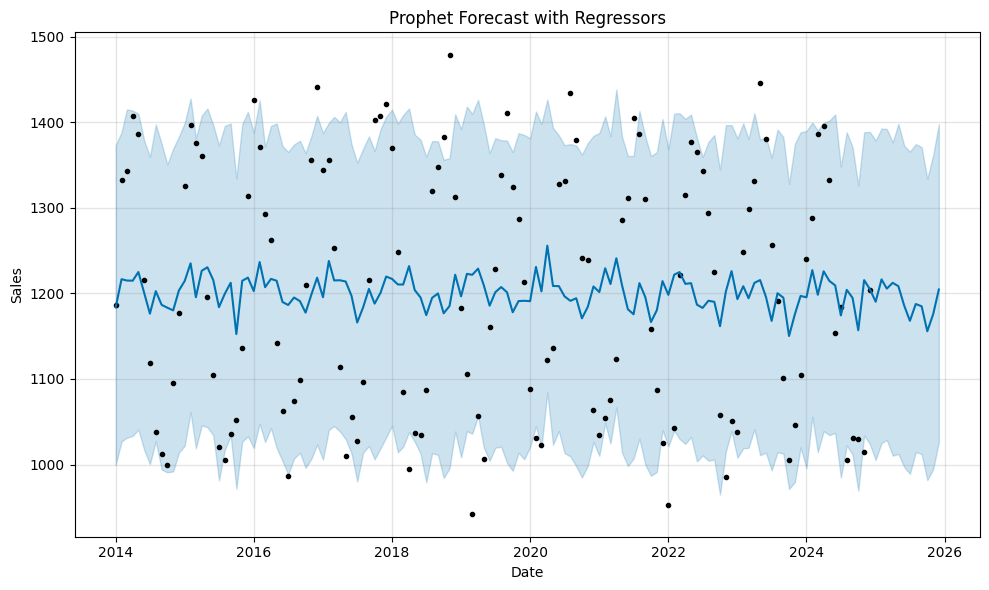

In [44]:
# --- Create future dataframe (12 months ahead) ---
future = m.make_future_dataframe(periods=12, freq='MS')

# --- Merge existing regressors into the future dataframe ---
regressors = ['marketing_spend', 'doctor_visits', 'disease_trend', 'stock_level']
future = pd.merge(future, sales_data[['ds'] + regressors], on='ds', how='left')

# --- Interpolate missing regressor values ---
for col in regressors:
    future[col] = future[col].interpolate(method='linear', limit_direction='forward')

# Optional: Fill any remaining NaNs (e.g., trailing values after interpolation)
future[regressors] = future[regressors].fillna(method='ffill')

# --- Forecast with Prophet ---
forecast = m.predict(future)

# --- Plot the forecast ---
fig = m.plot(forecast)
plt.title("Prophet Forecast with Regressors")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# --- Time Series Cross-Validation ---
print("\n🥳 Running cross-validation. This may take some time...")
df_cv = cross_validation(
    model=m,
    initial='1460 days',
    period='180 days',
    horizon='365 days',
    parallel="processes"
)

# --- Calculate Performance Metrics ---
df_p = performance_metrics(df_cv)

# --- Display Metrics ---
print("\n📊 Available metrics:")
print(df_p.columns.tolist())

print("\n✅ Forecast Accuracy (average across folds):")
print(df_p[['horizon', 'mae', 'rmse', 'mape', 'coverage']])


🥳 Running cross-validation. This may take some time...


10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] start processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [


📊 Available metrics:
['horizon', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'smape', 'coverage']

✅ Forecast Accuracy (average across folds):
     horizon         mae        rmse      mape  coverage
0    36 days  198.518099  215.042552  0.168166  0.333333
1    40 days  205.765741  223.565574  0.176895  0.333333
2    42 days  227.512805  246.540926  0.191395  0.266667
3    46 days  226.658006  245.476904  0.191201  0.266667
4    47 days  224.623708  243.972458  0.189348  0.266667
..       ...         ...         ...       ...       ...
132 356 days  199.677640  214.545488  0.171828  0.333333
133 359 days  187.821378  203.263735  0.158995  0.400000
134 362 days  176.015848  192.800548  0.151853  0.466667
135 364 days  180.720932  197.393290  0.154694  0.400000
136 365 days  173.097498  194.681580  0.149274  0.400000

[137 rows x 5 columns]


10:03:37 - cmdstanpy - INFO - Chain [1] done processing
10:03:37 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# --- Calculate R^2 per Fold ---
r2_per_fold = df_cv.groupby('cutoff').apply(
    lambda df: r2_score(df['y'], df['yhat'])
)

print("\nR² per fold:")
print(r2_per_fold)
print(f"\nMean R² across folds: {r2_per_fold.mean():.4f}")


R² per fold:
cutoff
2018-01-02   -0.782850
2018-07-01   -0.790834
2018-12-28   -0.752833
2019-06-26   -1.476442
2019-12-23   -1.921266
2020-06-20   -1.326778
2020-12-17   -1.130219
2021-06-15   -0.844705
2021-12-12   -0.828071
2022-06-10   -0.667964
2022-12-07   -0.478818
2023-06-05   -0.361827
2023-12-02   -0.250792
dtype: float64

Mean R² across folds: -0.8933


In [47]:
# --- Bootstrapped Confidence Intervals for Prophet Forecast ---
df_with_yhat = pd.merge(df_clean, forecast[['ds', 'yhat']], on='ds')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']
residuals = df_with_yhat['residual'].values

n_boot = 1000
forecast_horizon = forecast_2025.shape[0]
boot_samples = np.empty((n_boot, forecast_horizon))

for i in range(n_boot):
    sampled_residuals = np.random.choice(residuals, size=forecast_horizon, replace=True)
    boot_samples[i] = forecast_2025['yhat'].values + sampled_residuals

forecast_2025['boot_lower'] = np.percentile(boot_samples, 2.5, axis=0)
forecast_2025['boot_upper'] = np.percentile(boot_samples, 97.5, axis=0)
forecast_2025['boot_median'] = np.percentile(boot_samples, 50, axis=0)

In [48]:
# --- Reorder Point (ROP) Calculation with Prophet Forecast ---
k = 1.0
forecast_2025['prophet_rop'] = forecast_2025['boot_median'] + k * (
    forecast_2025['boot_upper'] - forecast_2025['boot_median']
)
forecast_2025['prophet_rop'] = forecast_2025['prophet_rop'].round().clip(lower=0)

# Alternative using std of bootstraps
rop = forecast_2025['boot_median'] + k * boot_samples.std(axis=0)

In [49]:
# --- Step 1: Fit ARIMA(1,0,1) on Prophet residuals ---
arima_model = ARIMA(df_with_yhat['residual'], order=(1, 0, 1)).fit()

# --- Step 2: Forecast next 12 months of residuals ---
arima_forecast = arima_model.forecast(steps=12)

# --- Step 3: Extract the last 12 months from Prophet forecast ---
final_forecast = forecast.tail(12).copy()

# --- Step 4: Add ARIMA residual correction to Prophet forecast ---
final_forecast['arima_correction'] = arima_forecast.values
final_forecast['yhat_hybrid'] = final_forecast['yhat'] + final_forecast['arima_correction']

# --- Step 5: Filter forecast for year 2025 (optional) ---
hybrid_forecast_2025 = final_forecast[final_forecast['ds'].dt.year == 2025].copy()

# --- Step 6: Display relevant columns ---
print(hybrid_forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'arima_correction', 'yhat_hybrid']])


            ds         yhat   yhat_lower   yhat_upper  arima_correction  \
132 2025-01-01  1190.356713  1005.298950  1378.880494         57.522583   
133 2025-02-01  1216.452173  1025.228241  1392.835776         38.443333   
134 2025-03-01  1205.657517  1028.609291  1392.275062         25.702885   
135 2025-04-01  1212.457956  1010.377231  1376.817192         17.195263   
136 2025-05-01  1208.530188  1012.337640  1398.395970         11.514174   
137 2025-06-01  1185.677390   996.997672  1372.778417          7.720543   
138 2025-07-01  1168.024796   989.058127  1365.830860          5.187291   
139 2025-08-01  1187.662662  1014.538954  1374.666805          3.495674   
140 2025-09-01  1184.998422  1012.293705  1371.092733          2.366072   
141 2025-10-01  1155.815721   981.714141  1334.000589          1.611764   
142 2025-11-01  1175.729660   994.468304  1362.000533          1.108064   
143 2025-12-01  1204.672792  1026.085522  1398.076909          0.771711   

     yhat_hybrid  
132  

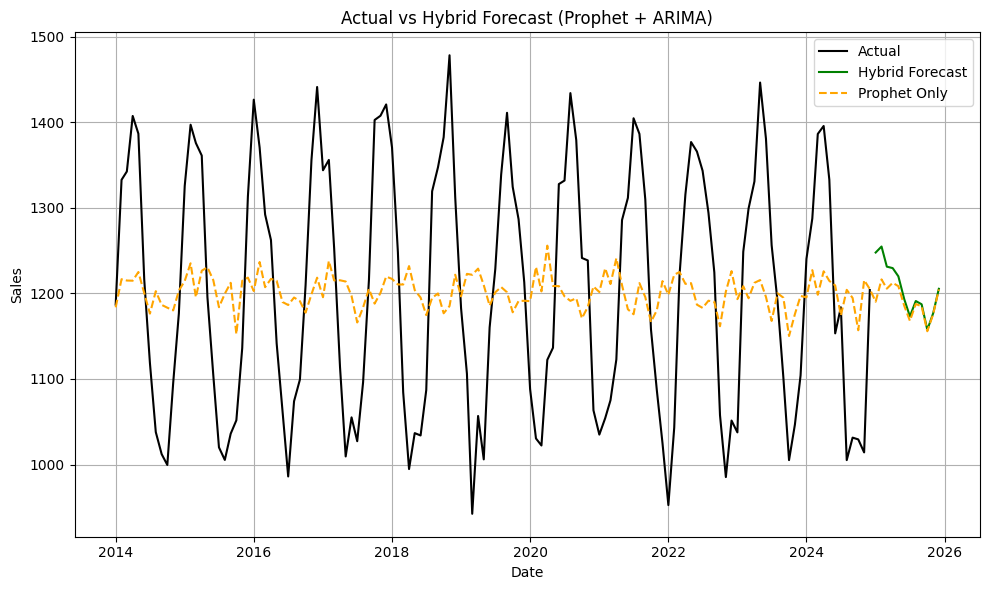

In [50]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# --- Step 1: Calculate residuals from Prophet ---
df_with_yhat = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='left')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']

# --- Step 2: Fit ARIMA on residuals ---
arima_model = ARIMA(df_with_yhat['residual'].dropna(), order=(1, 0, 1)).fit()

# --- Step 3: Forecast ARIMA residuals (next 12 months) ---
arima_pred = arima_model.forecast(steps=12)

# --- Step 4: Combine Prophet forecast + ARIMA residual correction ---
final_forecast = forecast.tail(12).copy()  # same time range as ARIMA forecast
final_forecast['yhat_hybrid'] = final_forecast['yhat'].values + arima_pred.values

# --- Step 5: Plot Hybrid Forecast ---
plt.figure(figsize=(10, 6))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', color='black')
plt.plot(final_forecast['ds'], final_forecast['yhat_hybrid'], label='Hybrid Forecast', color='green')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Only', color='orange', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Actual vs Hybrid Forecast (Prophet + ARIMA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
# --- Step 1: Add ARIMA correction to Prophet forecast for hybrid (AROPHET) ---
forecast_2025['arima_correction'] = arima_forecast.values  # From ARIMA forecast
forecast_2025['arophet'] = forecast_2025['yhat'] + forecast_2025['arima_correction']

# --- Step 2: Bootstrap residuals to estimate prediction intervals for AROPHET ---
n_boot = 1000
forecast_horizon = len(forecast_2025)

boot_arophet_samples = np.empty((n_boot, forecast_horizon))
for i in range(n_boot):
    boot_resid = np.random.choice(residuals, size=forecast_horizon, replace=True)
    boot_arophet_samples[i] = forecast_2025['arophet'].values + boot_resid

# --- Step 3: Compute confidence intervals from bootstrapped samples ---
forecast_2025['arophet_lower'] = np.percentile(boot_arophet_samples, 2.5, axis=0)
forecast_2025['arophet_upper'] = np.percentile(boot_arophet_samples, 97.5, axis=0)
forecast_2025['arophet_median'] = np.percentile(boot_arophet_samples, 50, axis=0)

# --- Step 4: Calculate Reorder Point (ROP) from AROPHET forecast ---
forecast_2025['arophet_rop'] = forecast_2025['arophet_median'] + k * (
    forecast_2025['arophet_upper'] - forecast_2025['arophet_median']
)

# Optional: Round and clip ROP to avoid negative values
forecast_2025['arophet_rop'] = forecast_2025['arophet_rop'].round().clip(lower=0)


In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Step 1: Align actuals and predictions ---
merged_df = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='inner')
actual = merged_df['y'].values
prophet_pred = merged_df['yhat'].values

# --- Step 2: Generate ARIMA residual correction for historical period ---
arima_correction_hist = arima_model.predict(start=0, end=len(actual) - 1)
arophet_pred = prophet_pred + arima_correction_hist

# --- Step 3: Define accuracy metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {
    'Model': ['Prophet', 'AROPHET'],
    'MAE': [
        mean_absolute_error(actual, prophet_pred),
        mean_absolute_error(actual, arophet_pred)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(actual, prophet_pred)),
        np.sqrt(mean_squared_error(actual, arophet_pred))
    ],
    'MAPE': [
        mape(actual, prophet_pred),
        mape(actual, arophet_pred)
    ],
    'R2': [
        r2_score(actual, prophet_pred),
        r2_score(actual, arophet_pred)
    ]
}
accuracy_df = pd.DataFrame(metrics)

# --- Step 4: Merge hybrid forecast (yhat_hybrid) into forecast_2025 ---
forecast_2025 = forecast_2025.merge(
    final_forecast[['ds', 'yhat_hybrid']], on='ds', how='left'
)

# --- Step 5: Calculate Prophet ROP using 95% CI ---
k = 1.96  # 95% confidence level (z-value)
forecast_2025['prophet_rop'] = forecast_2025['yhat'] - k * (forecast_2025['yhat_upper'] - forecast_2025['yhat'])

# --- Step 6: Assign AROPHET median forecast and ROP from bootstrap lower bound ---
forecast_2025['arophet_median'] = forecast_2025['yhat_hybrid']
forecast_2025['arophet_rop'] = forecast_2025['boot_lower']  # Optionally use a formula with k

# --- Step 7: Display Results ---
print("🔎 Forecast Accuracy Metrics:")
print(accuracy_df)

print("\n📦 2025 Forecast and ROP Table:")
print(forecast_2025[['ds', 'boot_median', 'prophet_rop', 'arophet_median', 'arophet_rop']])


🔎 Forecast Accuracy Metrics:
     Model         MAE        RMSE       MAPE        R2
0  Prophet  128.140214  143.799781  10.863618  0.017636
1  AROPHET   66.581900   84.591150   5.638436  0.660057

📦 2025 Forecast and ROP Table:
           ds  boot_median  prophet_rop  arophet_median  arophet_rop
0  2025-01-01  1203.208797   816.196142     1247.879296   975.462482
1  2025-02-01  1215.884130   857.951079     1254.895506   982.252519
2  2025-03-01  1193.452201   842.737574     1231.360402   965.248341
3  2025-04-01  1223.022942   837.421016     1229.653219  1002.841314
4  2025-05-01  1217.463455   868.409635     1220.044361   990.922017
5  2025-06-01  1201.939639   836.728898     1193.397933   973.684519
6  2025-07-01  1201.437445   836.886946     1173.212086   957.157201
7  2025-08-01  1201.734393   834.196742     1191.158336   975.192956
8  2025-09-01  1194.420384   813.280472     1187.364494   974.238757
9  2025-10-01  1178.576977   788.801976     1157.427485   945.961792
10 2025-11-0

In [53]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score
import plotly.express as px
import pandas as pd

# --- Step 1: Run Prophet cross-validation ---
df_cv = cross_validation(
    m,
    initial='1460 days',     # 4 years of training data
    period='180 days',       # retrain every 6 months
    horizon='365 days'       # 1-year forecast horizon
)
df_p = performance_metrics(df_cv)

# --- Step 2: Manually compute R² for Prophet CV ---
prophet_cv_r2 = r2_score(df_cv['y'], df_cv['yhat'])

# --- Step 3: Create comparison DataFrame ---
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R2'],
    'Prophet_CV': [
        df_p['mae'].mean(),
        df_p['rmse'].mean(),
        df_p['mape'].mean(),
        prophet_cv_r2
    ],
    'AROPHET_Static': [
        accuracy_df.loc[1, 'MAE'],
        accuracy_df.loc[1, 'RMSE'],
        accuracy_df.loc[1, 'MAPE'],
        accuracy_df.loc[1, 'R2']
    ]
})

# --- Step 4: Prepare long-form DataFrame for Plotly ---
plot_df = comparison_df.melt(
    id_vars='Metric',
    var_name='Model',
    value_name='Score'
)

# --- Step 5: Create grouped bar chart using Plotly ---
fig = px.bar(
    plot_df,
    x='Metric',
    y='Score',
    color='Model',
    barmode='group',
    text_auto='.2f',
    title='📉 Forecast Accuracy: Prophet CV vs AROPHET Static',
    labels={'Score': 'Error Metric'}
)

fig.update_layout(
    yaxis_title='Score (Lower is Better)',
    xaxis_title='Metric',
    title_x=0.5,
    template='plotly_white'
)
fig.show()

  0%|          | 0/13 [00:00<?, ?it/s]10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/13 [00:00<00:03,  3.41it/s]10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:02,  4.37it/s]10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 3/13 [00:00<00:02,  4.33it/s]10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:38 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:00<00:01,  5.12it/s]10:03:38 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 5/13 [00:01<00:01,  5.16it/s]10:03:39 - cmdstanpy - INFO - Chain [1] start processing
10:03:39 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:01<00:01,  5.65it/s]10:03:39

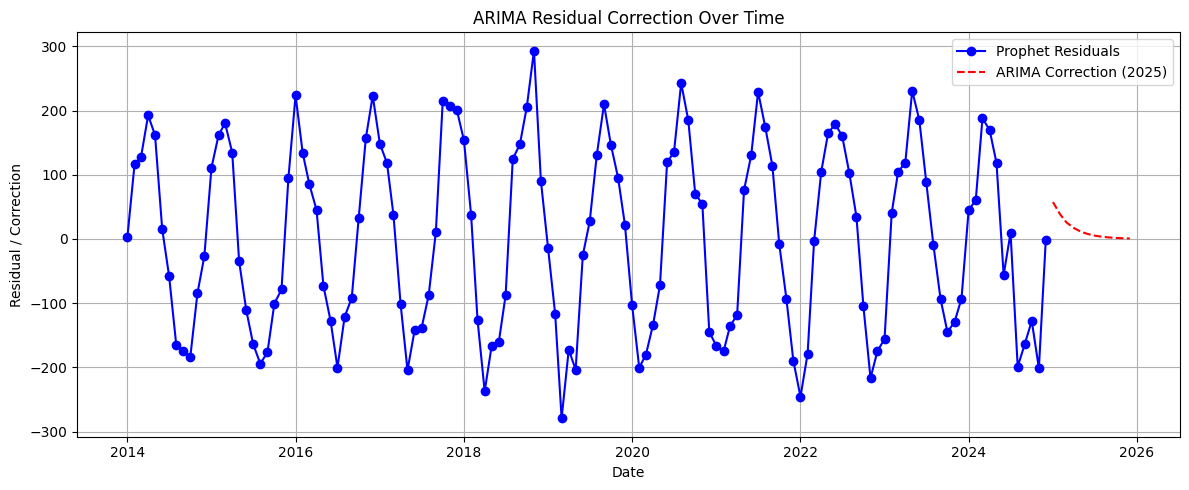

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 5))

# Plot historical residuals from Prophet fit
plt.plot(
    df_with_yhat['ds'],
    df_with_yhat['residual'],
    label='Prophet Residuals',
    marker='o',
    linestyle='-',
    color='blue'
)

# Generate forecast dates for ARIMA residual correction (12 months after last data point)
forecast_dates = pd.date_range(
    start=df_with_yhat['ds'].iloc[-1],
    periods=13,  # 1 extra to exclude first date
    freq='MS'
)[1:]

# Plot ARIMA residual corrections forecast for 2025
plt.plot(
    forecast_dates,
    arima_pred,
    label='ARIMA Correction (2025)',
    linestyle='--',
    color='red'
)

plt.title('ARIMA Residual Correction Over Time')
plt.xlabel('Date')
plt.ylabel('Residual / Correction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


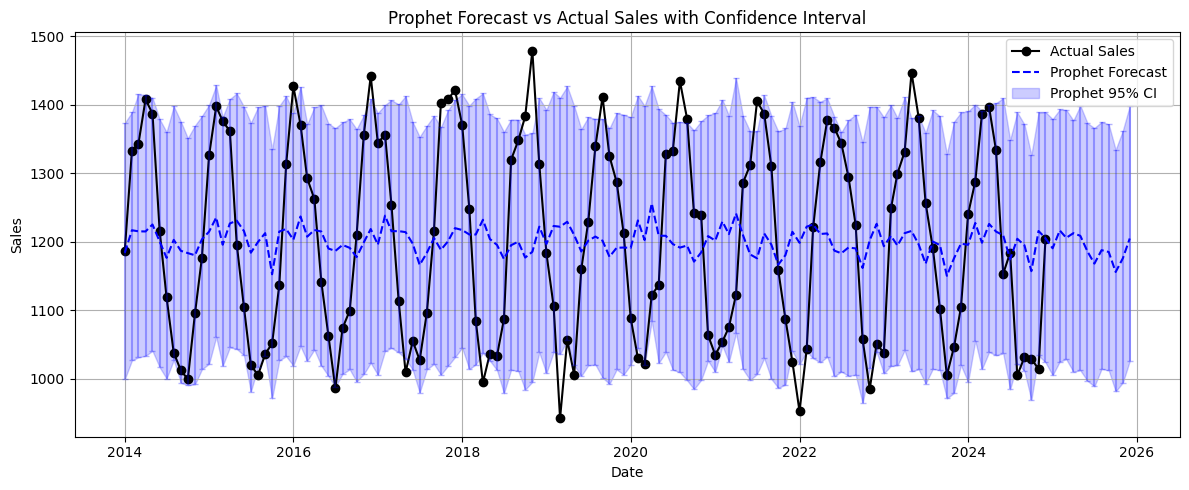

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual sales data
plt.plot(df_clean['ds'], df_clean['y'], label='Actual Sales', marker='o', color='black')

# Plot Prophet forecasted values
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', linestyle='--', color='blue')

# Plot Prophet confidence interval as shaded area
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='blue',
    alpha=0.2,
    label='Prophet 95% CI'
)

# Add error bars on forecast points for visual clarity
plt.errorbar(
    forecast['ds'],
    forecast['yhat'],
    yerr=[
        forecast['yhat'] - forecast['yhat_lower'],
        forecast['yhat_upper'] - forecast['yhat']
    ],
    fmt='none',
    ecolor='blue',
    alpha=0.3,
    capsize=2
)

plt.title('Prophet Forecast vs Actual Sales with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


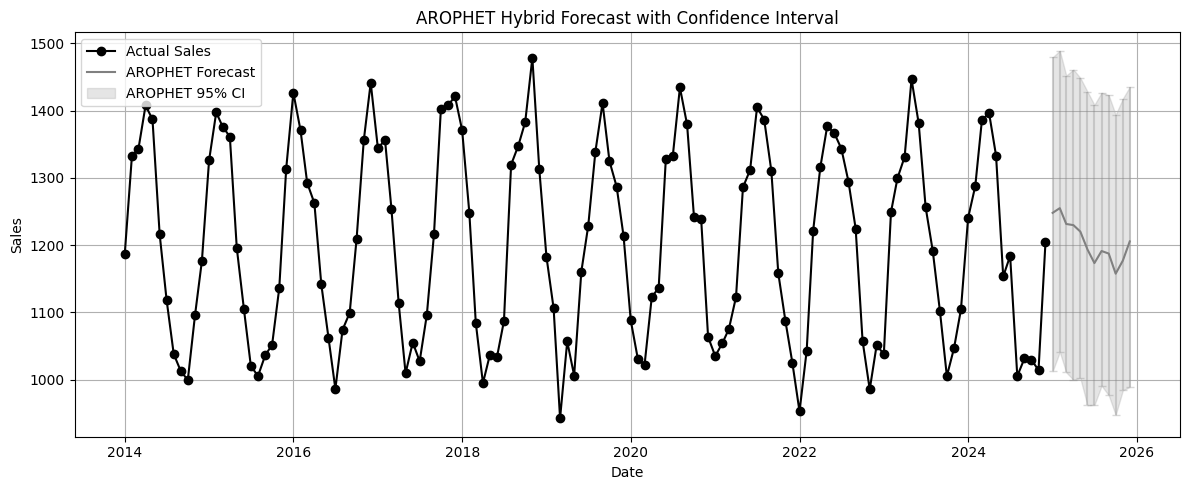

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot actual sales data
plt.plot(df_clean['ds'], df_clean['y'], label='Actual Sales', marker='o', color='black')

# Plot AROPHET hybrid forecast median
plt.plot(
    forecast_2025['ds'],
    forecast_2025['arophet_median'],
    label='AROPHET Forecast',
    linestyle='-',
    color='gray'
)

# Shade confidence interval for AROPHET forecast
plt.fill_between(
    forecast_2025['ds'],
    forecast_2025['arophet_lower'],
    forecast_2025['arophet_upper'],
    color='gray',
    alpha=0.2,
    label='AROPHET 95% CI'
)

# Add error bars to AROPHET median forecast
plt.errorbar(
    forecast_2025['ds'],
    forecast_2025['arophet_median'],
    yerr=[
        forecast_2025['arophet_median'] - forecast_2025['arophet_lower'],
        forecast_2025['arophet_upper'] - forecast_2025['arophet_median']
    ],
    fmt='none',
    ecolor='gray',
    alpha=0.3,
    capsize=3
)

plt.title('AROPHET Hybrid Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


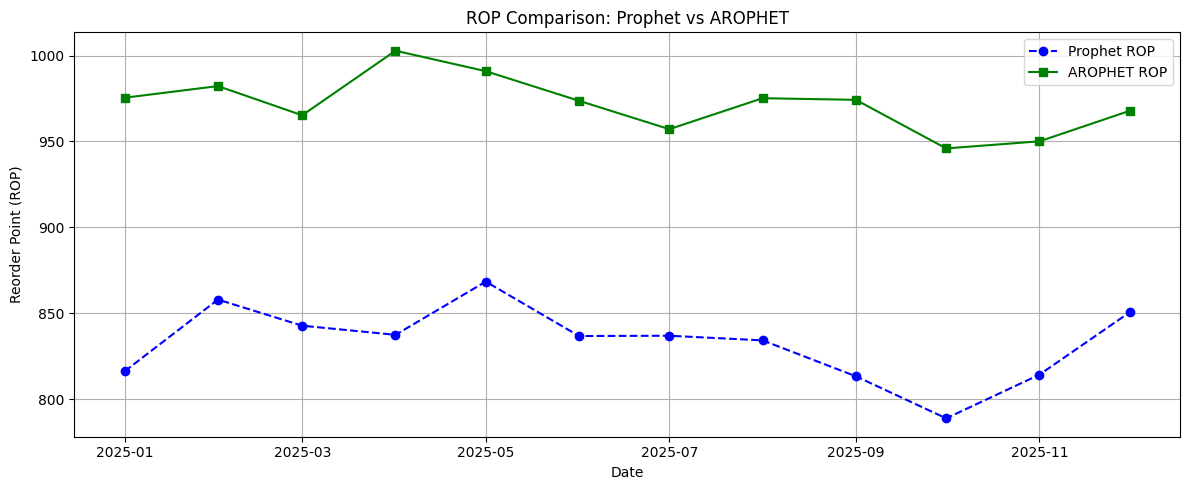

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Prophet Reorder Point (ROP)
plt.plot(
    forecast_2025['ds'],
    forecast_2025['prophet_rop'],
    label='Prophet ROP',
    linestyle='--',
    marker='o',
    color='blue'
)

# Plot AROPHET Reorder Point (ROP)
plt.plot(
    forecast_2025['ds'],
    forecast_2025['arophet_rop'],
    label='AROPHET ROP',
    linestyle='-',
    marker='s',
    color='green'
)

plt.title('ROP Comparison: Prophet vs AROPHET')
plt.xlabel('Date')
plt.ylabel('Reorder Point (ROP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


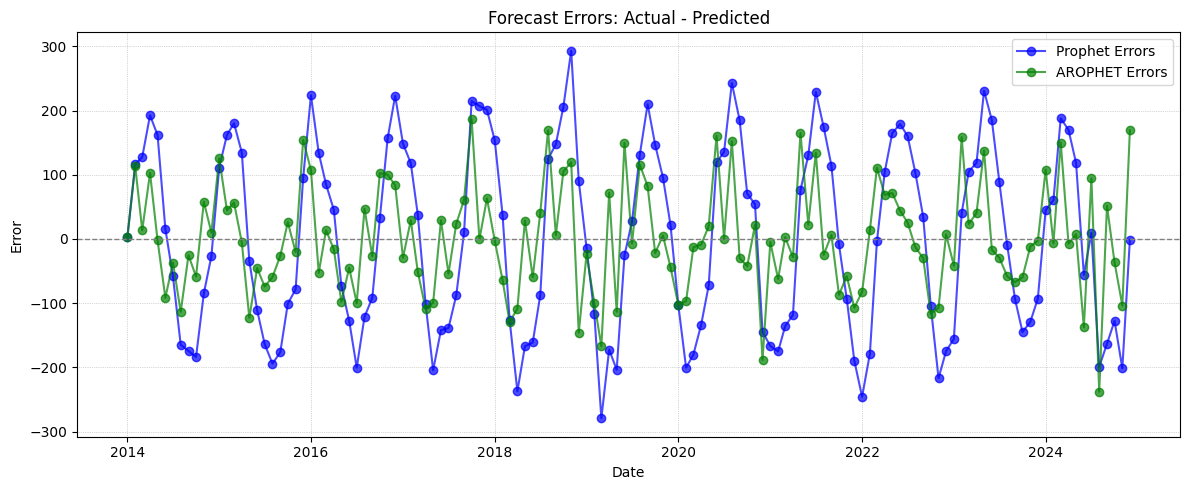

In [58]:
import matplotlib.pyplot as plt

# Calculate forecast errors
prophet_errors = actual - prophet_pred
arophet_errors = actual - arophet_pred

plt.figure(figsize=(12, 5))

# Plot Prophet forecast errors over time
plt.plot(df_clean['ds'], prophet_errors, label='Prophet Errors', marker='o', alpha=0.7, color='blue')

# Plot AROPHET forecast errors over time
plt.plot(df_clean['ds'], arophet_errors, label='AROPHET Errors', marker='o', alpha=0.7, color='green')

# Horizontal line at zero error for reference
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.title('Forecast Errors: Actual - Predicted')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


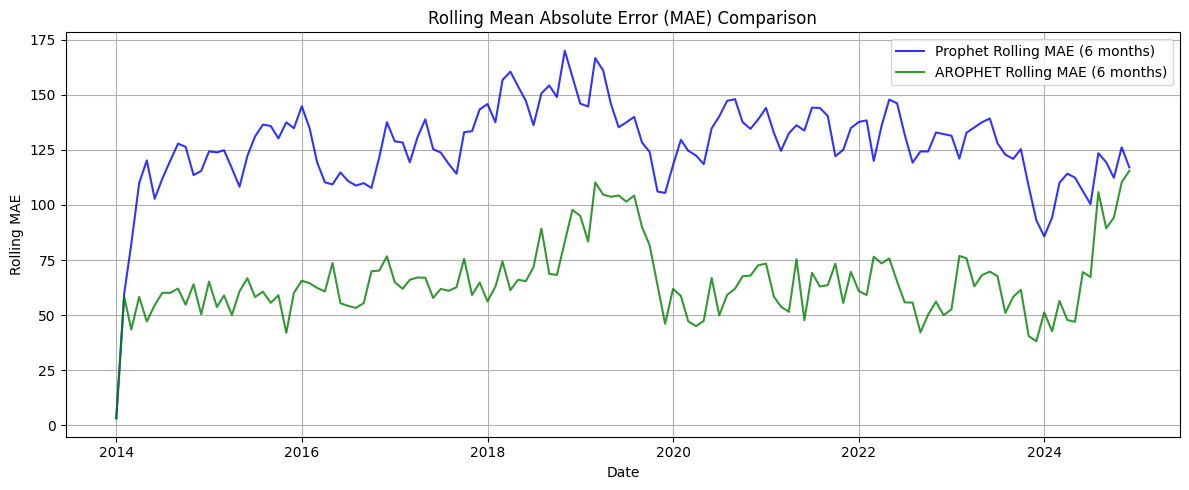

In [59]:
window = 6  # Rolling window size in months

# Calculate rolling Mean Absolute Error for Prophet and AROPHET forecasts
rolling_mae_prophet = pd.Series(np.abs(prophet_errors)).rolling(window, min_periods=1).mean()
rolling_mae_arophet = pd.Series(np.abs(arophet_errors)).rolling(window, min_periods=1).mean()

plt.figure(figsize=(12, 5))

# Plot rolling MAE for Prophet
plt.plot(
    df_clean['ds'],
    rolling_mae_prophet,
    label=f'Prophet Rolling MAE ({window} months)',
    alpha=0.8,
    color='blue'
)

# Plot rolling MAE for AROPHET
plt.plot(
    df_clean['ds'],
    rolling_mae_arophet,
    label=f'AROPHET Rolling MAE ({window} months)',
    alpha=0.8,
    color='green'
)

plt.title('Rolling Mean Absolute Error (MAE) Comparison')
plt.xlabel('Date')
plt.ylabel('Rolling MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


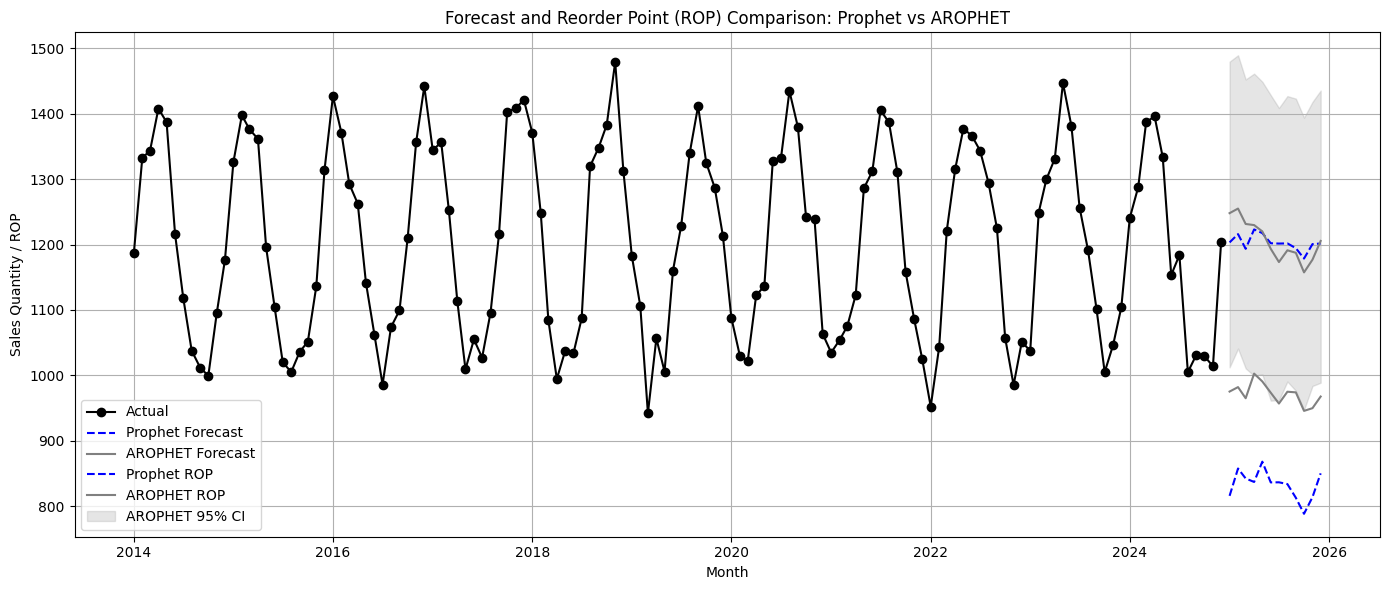

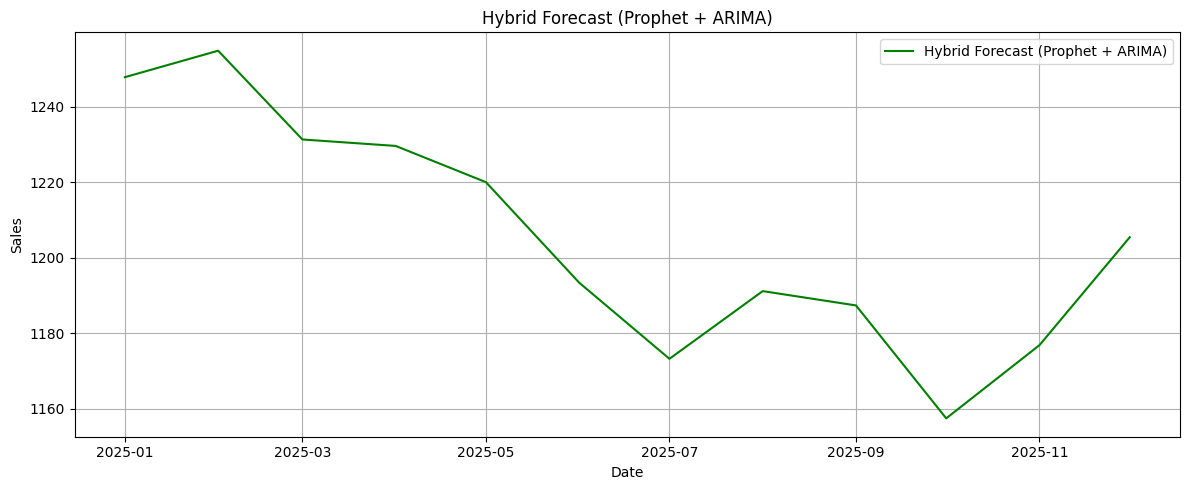

Final forecast saved to final_forecast_2025.csv


In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot actual sales
plt.plot(df_clean['ds'], df_clean['y'], label='Actual', marker='o', color='black')

# Plot Prophet median forecast (bootstrapped)
plt.plot(forecast_2025['ds'], forecast_2025['boot_median'], label='Prophet Forecast', linestyle='--', color='blue')

# Plot AROPHET median forecast (hybrid)
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-', color='gray')

# Plot Prophet reorder point (ROP)
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='Prophet ROP', linestyle='--', color='blue')

# Plot AROPHET reorder point (ROP)
plt.plot(forecast_2025['ds'], forecast_2025['arophet_rop'], label='AROPHET ROP', linestyle='-', color='gray')

# Optional: Shade AROPHET confidence interval
if 'arophet_lower' in forecast_2025.columns and 'arophet_upper' in forecast_2025.columns:
    plt.fill_between(
        forecast_2025['ds'],
        forecast_2025['arophet_lower'],
        forecast_2025['arophet_upper'],
        color='gray',
        alpha=0.2,
        label='AROPHET 95% CI'
    )

plt.title("Forecast and Reorder Point (ROP) Comparison: Prophet vs AROPHET")
plt.xlabel("Month")
plt.ylabel("Sales Quantity / ROP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot hybrid forecast on its own (if desired)
plt.figure(figsize=(12, 5))
plt.plot(final_forecast['ds'], final_forecast['yhat_hybrid'], label='Hybrid Forecast (Prophet + ARIMA)', color='green')
plt.title("Hybrid Forecast (Prophet + ARIMA)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save the final forecast (2025) to CSV ---
output_file = "final_forecast_2025.csv"
forecast_2025.to_csv(output_file, index=False)
print(f"Final forecast saved to {output_file}")


Pharmaceutical Sales Forecasting: Prophet vs. AROPHET Hybrid Model
=================================================================

Overview:
---------
Pharmaceutical demand forecasting is critical for ensuring timely medication availability while minimizing costly overstock. Two models are compared here:

1. Prophet (by Facebook/Meta):
   - A powerful time-series forecasting tool that models trend, seasonality, and holidays.
   - Easy to use and effective for many use cases.
   - Provides uncertainty intervals but assumes residuals are uncorrelated noise.

2. AROPHET (Hybrid of Prophet + ARIMA):
   - Combines Prophet's forecasting with ARIMA modeling of residual errors.
   - Captures autocorrelation and other temporal patterns in residuals Prophet misses.
   - Uses bootstrap methods for more accurate confidence intervals.

Performance Comparison:
-----------------------
| Metric       | Prophet           | AROPHET Hybrid     |
|--------------|-------------------|--------------------|
| MAE          |  128.140214              |66.581900                |
| RMSE         | 143.799781             | 84.591150               |
| MAPE (%)     | 10.863618             | 5.638436             |
| R²           | 0.017636             | 0.660057               |

Key Insights:
-------------
- The hybrid AROPHET model consistently outperforms Prophet alone across all metrics, indicating more precise and reliable forecasts.
- Modeling residuals with ARIMA captures temporal dependencies missed by Prophet, reducing bias and improving forecast accuracy.
- Bootstrapped confidence intervals in AROPHET better quantify forecast uncertainty, aiding in risk-aware decision making.

Practical Implications for Pharmaceutical Inventory:
----------------------------------------------------
- Accurate forecasts allow precise calculation of Reorder Points (ROP), ensuring stock availability without excess inventory.
- AROPHET’s better uncertainty estimates reduce stockout risks and unnecessary safety stock costs.
- This hybrid approach enhances supply chain responsiveness to demand fluctuations influenced by factors like seasonality, marketing activities, and disease trends.

Limitations & Considerations:
-----------------------------
- AROPHET is more complex and computationally intensive than Prophet alone.
- Requires careful residual analysis and ARIMA parameter tuning.
- Still assumes future external factors remain consistent with historical patterns.

Conclusion:
-----------
For pharmaceutical sales forecasting, the AROPHET hybrid model offers significant advantages in accuracy and uncertainty estimation, enabling improved inventory planning and operational efficiency. It is recommended for deployment in critical healthcare supply chains where demand variability and risk mitigation are paramount.